# Neural Network cartpole 

In [1]:
import gym
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import deque
import copy
import random

/home/hshwang/anaconda3/envs/pytorch/lib/python3.8/site-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


In [2]:
env = gym.make('CartPole-v1')
env._max_episode_steps=1000 # 기본 CarPole의 최대 maximum step은 500으로 고정 -> 필자는 1000으로 customizing
print(env._max_episode_steps)

1000


In [3]:
help(env.unwrapped)

Help on CartPoleEnv in module gym.envs.classic_control.cartpole object:

class CartPoleEnv(gym.core.Env)
 |  Description:
 |      A pole is attached by an un-actuated joint to a cart, which moves along
 |      a frictionless track. The pendulum starts upright, and the goal is to
 |      prevent it from falling over by increasing and reducing the cart's
 |      velocity.
 |  
 |  Source:
 |      This environment corresponds to the version of the cart-pole problem
 |      described by Barto, Sutton, and Anderson
 |  
 |  Observation:
 |      Type: Box(4)
 |      Num     Observation               Min                     Max
 |      0       Cart Position             -4.8                    4.8
 |      1       Cart Velocity             -Inf                    Inf
 |      2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
 |      3       Pole Angular Velocity     -Inf                    Inf
 |  
 |  Actions:
 |      Type: Discrete(2)
 |      Num   Action
 |      0  

In [4]:
s = env.reset()
n_state = s.shape[0]
n_action = env.action_space.n
print('State dimension',n_state)
print('Number of action option',n_action)

State dimension 4
Number of action option 2


In [5]:
# 아직 이 블럭코드는 실행하면 안됨! 구조만 짜놓기
def play_or_train_agent(env,agent,eps,train=True):
    '''
    목표: agent를 환경에 맞게 train할것인지 단순 play할것인지 구성
    입력인자
        env: environment(CartPole)
        agent: agnet
        eps: epsilon-greedy (초기: 1, 최종: 0.1밑으론 하락x)
        train: 학습여부(True: 학습, False: play)
    출력인자
        total_reward: 
        loss: 모니터링을 위한 TD error의 추이
    '''
    s = env.reset()
    total_reward = 0
    
    for t in range(env._max_episode_steps):
        #<! s로 부터 action추출>
        
        next_s,reward,done,_ = env.step(action)
        total_reward += reward
        
        if train:
            #<! TD loss계산 및 업데이트>
                
        s = next_s        
        if done:
            break
    return total_reward, loss

IndentationError: expected an indented block (<ipython-input-5-21ee323089b8>, line 26)

In [6]:
# 모델 만들기
# Q-function의 hidden layer는 sigmoid, tanh를 금기 -> Q-function값에 limitation을 걸 여지가 있음
# 마지막 layer에서는 activation function을 걸지 않도록 유의! 
class NN_model(nn.Module):
    def __init__(self,input_dim=n_state,output_dim=n_action):
        super(NN_model,self).__init__()
        '''
        입력변수
            input_dim: state의 차원 -> cartpole [위치, 속도, 각도, 각속도]
            output_dim: action의 차원 -> cartpole [왼쪽, 오른쪽]
        N.N 구조
            4 layer구조 (2 hidden layer).
            hidden node개수는 64개로 통일.
            activation function은 Relu 설정
        '''
        self.lin1 = nn.Linear(input_dim,100)
        self.lin2 = nn.Linear(100,100)
        self.lin3 = nn.Linear(100,output_dim)
        
    def forward(self,x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x
    
    def get_action(self,state,epsilon=0):
        '''
        목적: state로 부터 action추출
        입력인자
            state: 상태 -> shape[None,4]
            epsilon: epsilon, -> scalar
        출력인자
            action: gym integer [0 or 1] -> Cartpole
        '''
        x = torch.FloatTensor(state)
        Q_value = self.forward(x).detach().cpu().numpy()
        
        if np.random.uniform(0,1) < epsilon:
            action = np.argmax(np.random.uniform(0,1,size=Q_value.shape))
        else:
            action = np.argmax(Q_value)
        return int(action)
       
agent = NN_model()
optimizer = optim.Adam(agent.parameters(),lr=1e-03)

In [7]:
def TD_loss(state,action,reward,next_state,done,gamma=0.99,agent=agent):
    '''
    목적: TD loss계산후 agent 학습
        목적함수: (Reward+gammma*max_a{Q(s',a)} - Q(s,a))**2
    입력인자
        state: 상태
        action: 액션
        reward: 보상
        next_state: 다음상태
        done: 종료여부
        gamma: discount factor(할인율)
        agent: agent
    출력인자
        td_loss: 모니터링을 위한 TD error의 추이
    '''
    state = torch.FloatTensor(state)
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    next_state = torch.FloatTensor(next_state)
    done = torch.tensor(done,dtype=torch.uint8)
    
    Q_current = agent(state)
    Q_current = Q_current[range(state.shape[0]),action]

    Q_next = agent(next_state)
    Value_next = torch.max(Q_next,dim=1).values
    
    target_value = reward+gamma*Value_next
    target_value = torch.where(done,reward,target_value)
    
    td_loss = torch.mean((Q_current-target_value.detach())**2)
    return td_loss

In [8]:
# 이제 코드 블럭을 완성합시다
def play_or_train_agent(env,agent,optimizer,eps,train=False):
    '''
    목표: agent를 환경에 맞게 train할것인지 단순 play할것인지 구성
    입력인자
        env: environment(CartPole)
        agent: agnet
        optimizer: optimizer
        eps: epsilon-greedy (초기: 1, 최종: 0.2밑으론 하락x)
        train: 학습여부(True: 학습, False: play)
    출력인자
        total_reward:  최종보상
        loss: 모니터링을 위한 TD error의 추이
    '''
    total_reward = 0
    s = env.reset()

    while True:
        action = agent.get_action([s],epsilon=eps)
        
        new_s, reward, done, _ = env.step(action)
        total_reward += reward
        
        if train:
            optimizer.zero_grad()
            loss = TD_loss([s],[action],[reward],[new_s],[done],agent=agent)
            loss.backward()
            optimizer.step()
        
        s = new_s
        if done:
            break
    return total_reward, loss

Episode 49
Epsilon 0.30250303356876823


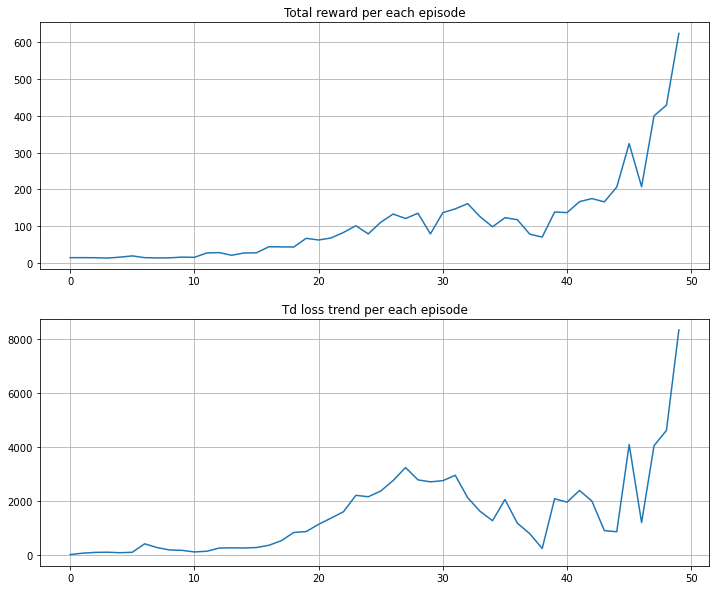

 49%|████▉     | 49/100 [04:25<04:36,  5.42s/it]

Agent finds solution! Final score : 624.32


In [10]:
# 주 학습 - 에피소드마다 reward, td_loss값의 추이를 지켜봅시다
from tqdm import trange
from IPython.display import clear_output

agent = NN_model()
optimizer = optim.Adam(agent.parameters(),lr=1e-04)

episode_rewards, TD_losses = [], []
max_episodes = 100
mini_sessions = 50

eps = 0.5
for episode in trange(max_episodes):
    mini_reward, mini_td = [], []
    for mini_session in range(mini_sessions):
        episode_reward, td_loss = play_or_train_agent(env,agent=agent,optimizer=optimizer,eps=eps,train=True)
        mini_reward.append(episode_reward)
        mini_td.append(td_loss.item())
    
    eps *= 0.99
    if eps < 1e-04:
        eps=0.1
    
    episode_rewards.append(np.mean(mini_reward))
    TD_losses.append(np.mean(mini_td))
    
    clear_output(True)
    print("Episode",episode)
    print("Epsilon",eps)
    
    plt.figure(figsize=[12, 10])
    plt.subplot(2,1,1)
    plt.title("Total reward per each episode")
    plt.plot(episode_rewards)
    plt.grid()
    
    plt.subplot(2,1,2)
    plt.title("Td loss trend per each episode")
    plt.plot(TD_losses)
    plt.grid()
    
    plt.show()
    
    if np.mean(mini_reward) >= 500:
        print(f"Agent finds solution! Final score : {np.mean(mini_reward)}")
        break

In [12]:
torch.save(agent,'./NN_cartpole.pth')

In [ ]:
# 플레이 해봅시다!
